# lesson 1: Handwritten Digit Recognition

Learn how to do digit recognition with pytorch

Sources:
- https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
- https://www.kaggle.com/code/simonedegasperis/pytorch-digitrecognizer/edit

## Import libraries

In [1]:
# import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torchvision import datasets, transforms
from pathlib import Path
import scipy as sp
import random
import pandas as pd
import itertools
import torch
import torch.nn as nn
from torch.autograd import Variable

## Download MNIST dataset

In [2]:
# check if GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
source_path = Path().absolute().parent

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [5]:
# download train and validation datasets
trainset = datasets.MNIST(os.path.join(source_path, 'others', 'dataset', 'train'), download=True, train=True, transform=transform)
valset = datasets.MNIST(os.path.join(source_path, 'others', 'dataset', 'val'), download=True, train=False, transform=transform)

In [6]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=False)
validation_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False)

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


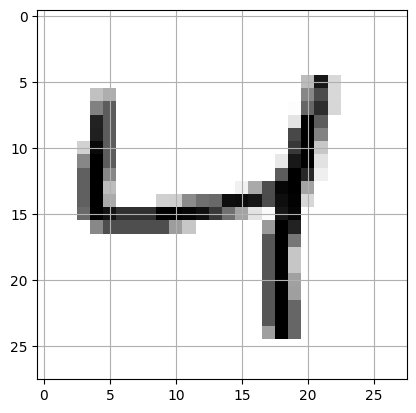

In [8]:
# Let's display an image
plt.imshow(images[2].numpy().squeeze(), cmap='gray_r')
plt.grid()

## Build the neural network

In [9]:
# Create simple CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

In [10]:
# Create CNN
model = CNNModel()
model = model.to(device)

In [11]:
# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
# define parameters for traning
# batch_size, epoch and iteration
n_iters = 10000
num_epochs = n_iters / (len(trainset) / batch_size)
num_epochs = int(num_epochs)
num_epochs

10

# Training

In [13]:
def train(model, optimizer, error, num_epochs, train_loader, validation_loader):
    
    def calculate_accuracy(model, dataloader, device):
        # Calculate Train Accuracy         
        correct = 0
        total = 0
        # Predict validation dataset
        for images, labels in dataloader:

            # move to gpu 
            images = images.to(device)
            labels = labels.to(device)

            train_images = Variable(images.view(images.shape[0],1,28,28))

            # Forward propagation
            outputs = model(train_images)

            # Get predictions from the maximum value
            predicted = torch.max(outputs.data, 1)[1]

            # Total number of labels
            total += len(labels)

            # Total correct predictions
            correct += (predicted == labels).sum()


        accuracy = 100 * correct / float(total)
        return accuracy
        
    
    # ANN model training
    count = 0
    iteration_list = []
    log_dict = {
        'training_loss_per_batch': [],
        'validation_loss_per_batch': [],
        'training_accuracy_per_epoch': [],
        'validation_accuracy_per_epoch': []
    } 
        
    #  training
    print('training...')
    
    best_metric = -999
    
    
    for epoch in range(num_epochs):
        train_losses = []
        for i, (images, labels) in enumerate(train_loader):
            
            # move to gpu 
            images = images.to(device)
            labels = labels.to(device)

            train = Variable(images.view(images.shape[0],1,28,28))
            labels = Variable(labels)

            # Clear gradients
            optimizer.zero_grad()

            # Forward propagation
            outputs = model(train)

            # Calculate softmax and cross entropy loss
            loss = error(outputs, labels)

            # Calculating gradients
            loss.backward()

            # Update parameters
            optimizer.step()
            
            # store loss and iteration
            log_dict['training_loss_per_batch'].append(loss.data)
            train_losses.append(loss.item())
            iteration_list.append(count)

            count += 1
            if count % 100 == 0:
                print("Iteration:", count)

        # calculate train accuracy
        accuracy = calculate_accuracy(model, train_loader, device)
        log_dict['training_accuracy_per_epoch'].append(accuracy)
        
        #  validation
        # setting model to evaluation mode
        model.eval()
        with torch.no_grad():
            val_losses = []
            for images, labels in validation_loader:
                # sending data to device
                images, labels = images.to(device), labels.to(device)
                val = Variable(images.view(images.shape[0],1,28,28))
                #  making predictions
                predictions = model(val)
                #  computing loss
                val_loss = error(predictions, labels)
                log_dict['validation_loss_per_batch'].append(val_loss.item())
                val_losses.append(val_loss.item())
                
        val_accuracy = calculate_accuracy(model, validation_loader, device)
        log_dict['validation_accuracy_per_epoch'].append(val_accuracy)

        # Print metrics
        print('Epoch: {}  Train loss: {}  Train accuracy: {} % Val loss: {}  Val accuracy: {} %'.format(epoch, np.array(train_losses).mean(), accuracy, np.array(val_losses).mean(), val_accuracy))

        # Check if current performance is better than the best so far by checking the val accuracy
        if val_accuracy > best_metric:
            best_metric = val_accuracy
            best_epoch = epoch

            # Save the model checkpoint
            torch.save(model.state_dict(), 'best_model.pt')
        
    return (iteration_list, log_dict)

In [15]:
iteration_list, log_dict = train(model, optimizer, error, num_epochs, train_loader, validation_loader)

training...
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
Epoch: 0  Train loss: 0.16797746357414672  Train accuracy: 98.461669921875 % Val loss: 0.04573261934024086  Val accuracy: 98.52999877929688 %
Iteration: 1000
Iteration: 1100
Iteration: 1200
Iteration: 1300
Iteration: 1400
Iteration: 1500
Iteration: 1600
Iteration: 1700
Iteration: 1800
Epoch: 1  Train loss: 0.05284316171005841  Train accuracy: 98.70166778564453 % Val loss: 0.044529329068887576  Val accuracy: 98.54000091552734 %
Iteration: 1900
Iteration: 2000
Iteration: 2100
Iteration: 2200
Iteration: 2300
Iteration: 2400
Iteration: 2500
Iteration: 2600
Iteration: 2700
Iteration: 2800
Epoch: 2  Train loss: 0.04002169842609882  Train accuracy: 98.94499969482422 % Val loss: 0.037357215462608416  Val accuracy: 98.70999908447266 %
Iteration: 2900
Iteration: 3000
Iteration: 3100
Iteration: 3200
Iteration: 3300
Iteration: 3400
Iteration: 3500
Itera

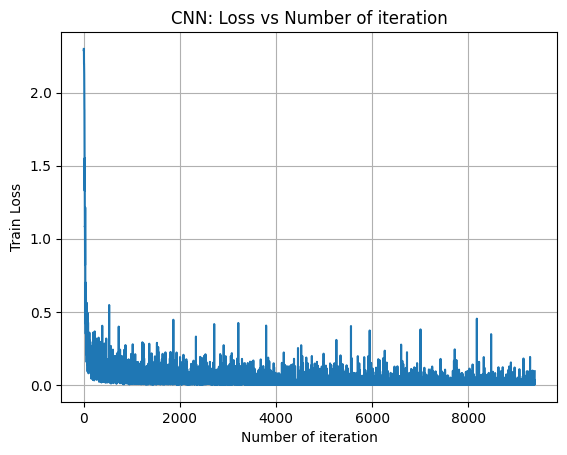

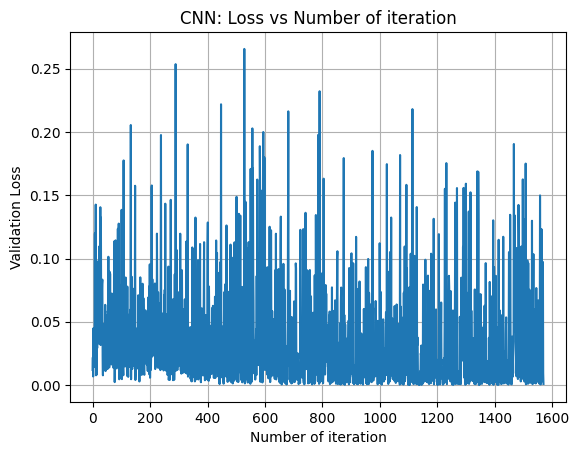

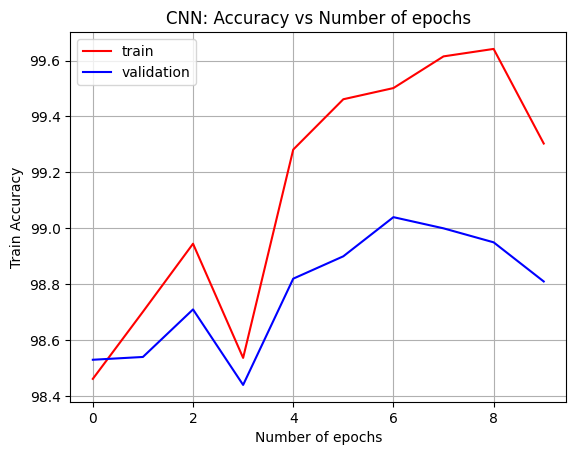

In [17]:
# visualization loss 
plt.plot(log_dict['training_loss_per_batch'])
plt.xlabel("Number of iteration")
plt.ylabel("Train Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.grid()
plt.show()

# visualization loss 
plt.plot(log_dict['validation_loss_per_batch'])
plt.xlabel("Number of iteration")
plt.ylabel("Validation Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.grid()
plt.show()

# visualization accuracy 
plt.plot(log_dict['training_accuracy_per_epoch'], color = "red", label='train')
plt.plot(log_dict['validation_accuracy_per_epoch'], color = "blue", label='validation')
plt.xlabel("Number of epochs")
plt.ylabel("Train Accuracy")
plt.title("CNN: Accuracy vs Number of epochs")
plt.grid()
plt.legend()
plt.show()

In [15]:
# Disable grad and do predictions on the validation set
predictions = []
gt = []
with torch.no_grad():
    for i, (images, labels) in enumerate(validation_loader):
        
        # move to gpu 
        images = images.to(device)
        labels = labels.to(device)
        
        val = Variable(images.view(images.shape[0],1,28,28))
        labels = Variable(labels)
            
        outputs = model(val)
        output = [torch.argmax(out).item() for out in outputs]
        label = [lab.item() for lab in labels]
        predictions.extend(output)
        gt.extend(label)

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

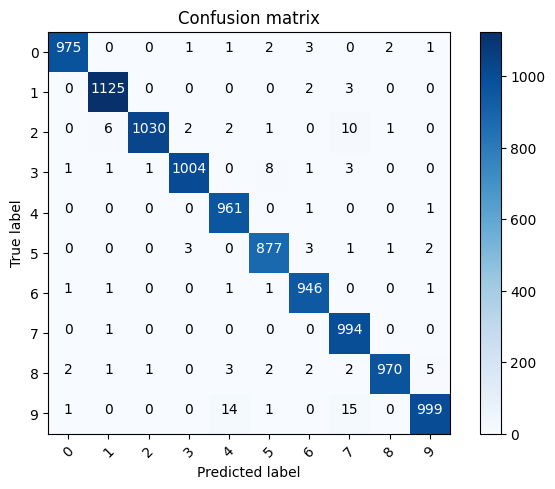

In [17]:
# compute the confusion matrix, this is good way to visulize results for each class
# prediction are x-axis while true label are shown on the y-axis
confusion_mtx = confusion_matrix(predictions, gt) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [18]:
# print report with precision, recall and f1-support
print('\n', classification_report(gt, 
                                  predictions, 
                                  target_names=["0","1","2","3","4","5","6","7","8","9"]))


               precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.98      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.99      0.99       958
           7       1.00      0.97      0.98      1028
           8       0.98      1.00      0.99       974
           9       0.97      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [74]:
# let's save the trained model
torch.save(model.state_dict(), "best_model.pt")

In [14]:
# to load the model
model = CNNModel()
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)

Prediction:6


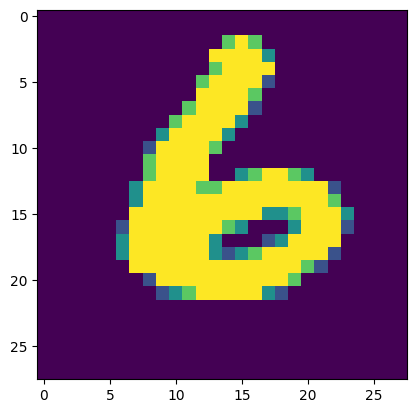

In [19]:
# Visulize predictions
# Some examples
random_number = random.randint(0, len(predictions)-1)
            
# Get a random element from the dataset
random_element = valset[random_number][0]

plt.imshow(np.squeeze(random_element.numpy()))
print("Prediction:{:d}".format(predictions[random_number]))

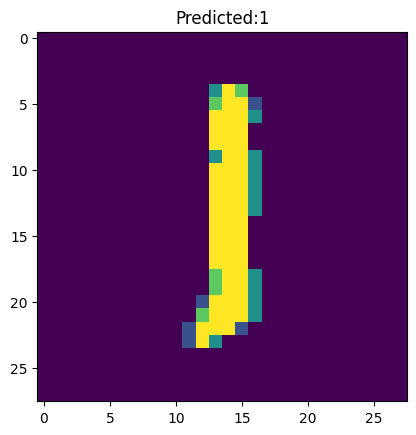

In [20]:
dst_folder = os.path.join(source_path, 'others', 'output')

if not os.path.exists(dst_folder):
    os.makedirs(dst_folder)
    
for count in range(0, 15):
    random_element = valset[count][0]
    plt.imshow(np.squeeze(random_element.numpy()))
    plt.title("Predicted:{:d}".format(predictions[count]))
    plt.savefig(os.path.join(dst_folder, str(count)+'.jpg'))

### Save video

In [25]:
def generate_video_from_frames(frames_folder, output_video_path, fps=1.0):
    ''' function used to generate a video from a folder containing frames'''
    image_files = os.listdir(frames_folder)
    image_path = os.path.join(frames_folder, str(image_files[0]))
    print(image_path)
    frame = cv2.imread(image_path)
    height, width, _ = frame.shape

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*"XVID")  # Use "XVID" codec for AVI format
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    for image_file in image_files:
        image_path = os.path.join(frames_folder, str(image_file))
        frame = cv2.imread(image_path)

        # Write the frame to the video
        video_writer.write(frame)

    # Release the VideoWriter object
    video_writer.release()

In [26]:
# Generate output video
frames_folder_path = dst_folder
output_video_path = os.path.join(source_path, 'Data', 'digit_video.avi')
generate_video_from_frames(frames_folder_path, output_video_path)

C:\Users\degas\Documents\Github\Python_Image_Processing\others\output\0.jpg
